In [ ]:
import pickle as pkl
import pandas as pd
import os, sys
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, accuracy_score
import warnings

warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
sys.path.append('../')
from utils import eAURC


In [32]:
root_dir = '../../'
eval_dir = 'results/main_results/'
rows = []

source_translator = {
    'normal': 'Non-Adversarial',
    'adversarial': 'Adversarial',
    'score-agreement-2': 'Score Agreement N=2',
    'score-agreement-15': 'Score Agreement N=15',
}

hue_order = ['Non-Adversarial', 'Adversarial', 'Score Agreement N=2', 'Score Agreement N=15']
# quantiles = {
#     'mnmv2': {
#         'dice': {
#             'q_80': 0.8923393249511719,
#             'q_90': 0.8359943747520446,
#             'q_95': 0.7769947648048401
#         }, 
#         'surface_dice': {
#             'q_80': 0.8987622618675232,
#             'q_90': 0.6623743534088135, 
#             'q_95': 0.5472338736057282
#         }
#     }, 
#     'pmri': {
#         'dice': {
#             'q_80': 0.8656453490257263,
#             'q_90': 0.7885498404502869,
#             'q_95': 0.7842167615890503
#         }, 
#         'surface_dice': {
#             'q_80': 0.5677419304847717,
#             'q_90': 0.49848026037216187, 
#             'q_95': 0.36147186160087585
#         }
#     }
# }

quantiles = {
    'mnmv2': {
        'dice': {
            'q_80': 0.8865002393722534, 
            'q_90': 0.8443227410316467, 
            'q_95': 0.7935258209705353
        }, 
        'surface_dice': {
            'q_80': 0.8983537554740906, 
            'q_90': 0.6614245891571044, 
            'q_95': 0.5942456066608429
        }
    }, 
    'pmri': {
        'dice': {
            'q_80': 0.9288250088691712, 
            'q_90': 0.9120014429092407, 
            'q_95': 0.8903486222028733
        }, 
        'surface_dice': {
            'q_80': 0.77085782289505, 
            'q_90': 0.6924475610256196,
            'q_95': 0.6237157493829727
        }
    }
}

val_t = 90
# get files for main methods
dirs = os.listdir(root_dir + eval_dir)
dirs = [d for d in dirs if 'Symphony' in d or 'RUNMC' in d]
dirs = [d for d in dirs if '2025' in d and 'in-domain' not in d]

# add rows to dataframe for each method and setting
for dir in dirs:
    file = pkl.load(open(root_dir + eval_dir + dir + '/eval_data.pkl', 'rb'))['evaluation']
    parts = dir.split('_')
    dataset = parts[0]
    source = parts[3]
    if 'finetune' in parts[4]:
        source += f'_{parts[4]}'
    score = parts[2]

    source = source_translator[source]

    for domain in file.keys():
        if 'train' in domain or 'val' in domain:
            continue
        corr = file[domain]['corr'][0].item()
        predicted_risks = torch.cat(file[domain]['predicted_risks'])
        true_risks = torch.cat(file[domain]['original_risks'])
        eaurc, true_risks_aggr, predicted_risks_aggr = eAURC(predicted_risks, true_risks, ret_curves=True)
        
        # print(score)
        score_key = score if score != 'surface' else 'surface_dice'
        threshold = 1 - quantiles[dataset][score_key][f'q_{val_t}']
        # print(f'{dataset} {source} {score} {domain} {threshold}')
        predicted_score_over_threshold = predicted_risks < threshold
        true_score_over_threshold = true_risks < threshold
        acc_at_threshold = accuracy_score(true_score_over_threshold.cpu().numpy(), predicted_score_over_threshold.cpu().numpy())
        frac_over_threshold = true_score_over_threshold.float().mean().item()
        mae = torch.abs(predicted_risks - true_risks).mean().item()

        # f1_at_thresholds = []
        # frac_over_thresholds = []
        # x = []
        
        # for threshold in torch.linspace(0, 1, 101):
        #     predicted_score_over_threshold = predicted_risks < threshold
        #     true_score_over_threshold = true_risks < threshold
        #     f1_at_thresholds.append(f1_score(true_score_over_threshold.cpu().numpy(), predicted_score_over_threshold.cpu().numpy()))
        #     frac_over_thresholds.append(true_score_over_threshold.float().mean().item())
        #     x.append(threshold.item())
        
        # predicted_score_at_50 = predicted_risks < 0.5
        # true_score_at_50 = true_risks < 0.5
        # f1_at_50 = f1_score(true_score_at_50.cpu().numpy(), predicted_score_at_50.cpu().numpy())

        # predicted_score_at_80 = predicted_risks < 0.2
        # true_score_at_80 = true_risks < 0.2
        # f1_at_80 = f1_score(true_score_at_80.cpu().numpy(), predicted_score_at_80.cpu().numpy())


        rows.append(
            {
                'dataset': dataset,
                'source': source,
                'score': score,
                'domain': domain,
                'corr': corr,
                'eaurc': eaurc.item(),
                f'acc_at_threshold': acc_at_threshold,
                f'frac_over_threshold': frac_over_threshold,
                'mae': mae,
            }
        )

        # rows.append(
        #     {
        #         'dataset': dataset,
        #         'source': source,
        #         'score': score,
        #         'domain': domain,
        #         'corr': corr,
        #         'eaurc': eaurc.item(),
        #         f'f1s': f1_at_thresholds,
        #         f'fracs': frac_over_thresholds,
        #         'x': x,
        #     }
        # )


# add rows for score agreement competitor
for root, _, files in os.walk(root_dir + eval_dir):
    for filename in files:
        if 'score-agreement' in filename:
            parts = filename.split('_')
            dataset = parts[0]
            source = parts[2].split('.')[0]

            if 'in-domain' in filename or 'train-val' in filename:
                continue


            if 'score-agreement-15' in source:
                source = source_translator['score-agreement-15']
            if 'score-agreement-2' in source:
                source = source_translator['score-agreement-2']
            data = torch.load(root + filename)
            for domain, values in data.items():
                if 'train' in domain or 'val' in domain:
                    continue

                volume_agreement = values['scores']['dice_agreement']
                volume_dice = values['scores']['dice']
                volume_corr = torch.corrcoef(torch.stack([volume_agreement, volume_dice], dim=0))[0,1].item()
                volume_predicted_risks = 1 - volume_agreement
                volume_true_risks = 1 - volume_dice
                volume_eaurc, _, _ = eAURC(volume_predicted_risks, volume_true_risks, ret_curves=True)


                rows.append(
                    {
                        'dataset': dataset,
                        'source': source,
                        'score': 'dice',
                        'domain': domain,
                        'corr': volume_corr,
                        'eaurc': volume_eaurc.item(),
                    }
                )
                
                surface_agreement = values['scores']['surface_agreement']
                surface_dice = values['scores']['surface']
                surface_corr = torch.corrcoef(torch.stack([surface_agreement, surface_dice], dim=0))[0,1].item()
                surface_predicted_risks = 1 - surface_agreement
                surface_true_risks = 1 - surface_dice
                surface_eaurc, _, _ = eAURC(surface_predicted_risks, surface_true_risks, ret_curves=True)

                rows.append(
                    {
                        'dataset': dataset,
                        'source': source,
                        'score': 'surface',
                        'domain': domain,
                        'corr': surface_corr,
                        'eaurc': surface_eaurc.item(),
                    }
                )


# combine to dataframe
df = pd.DataFrame(rows)


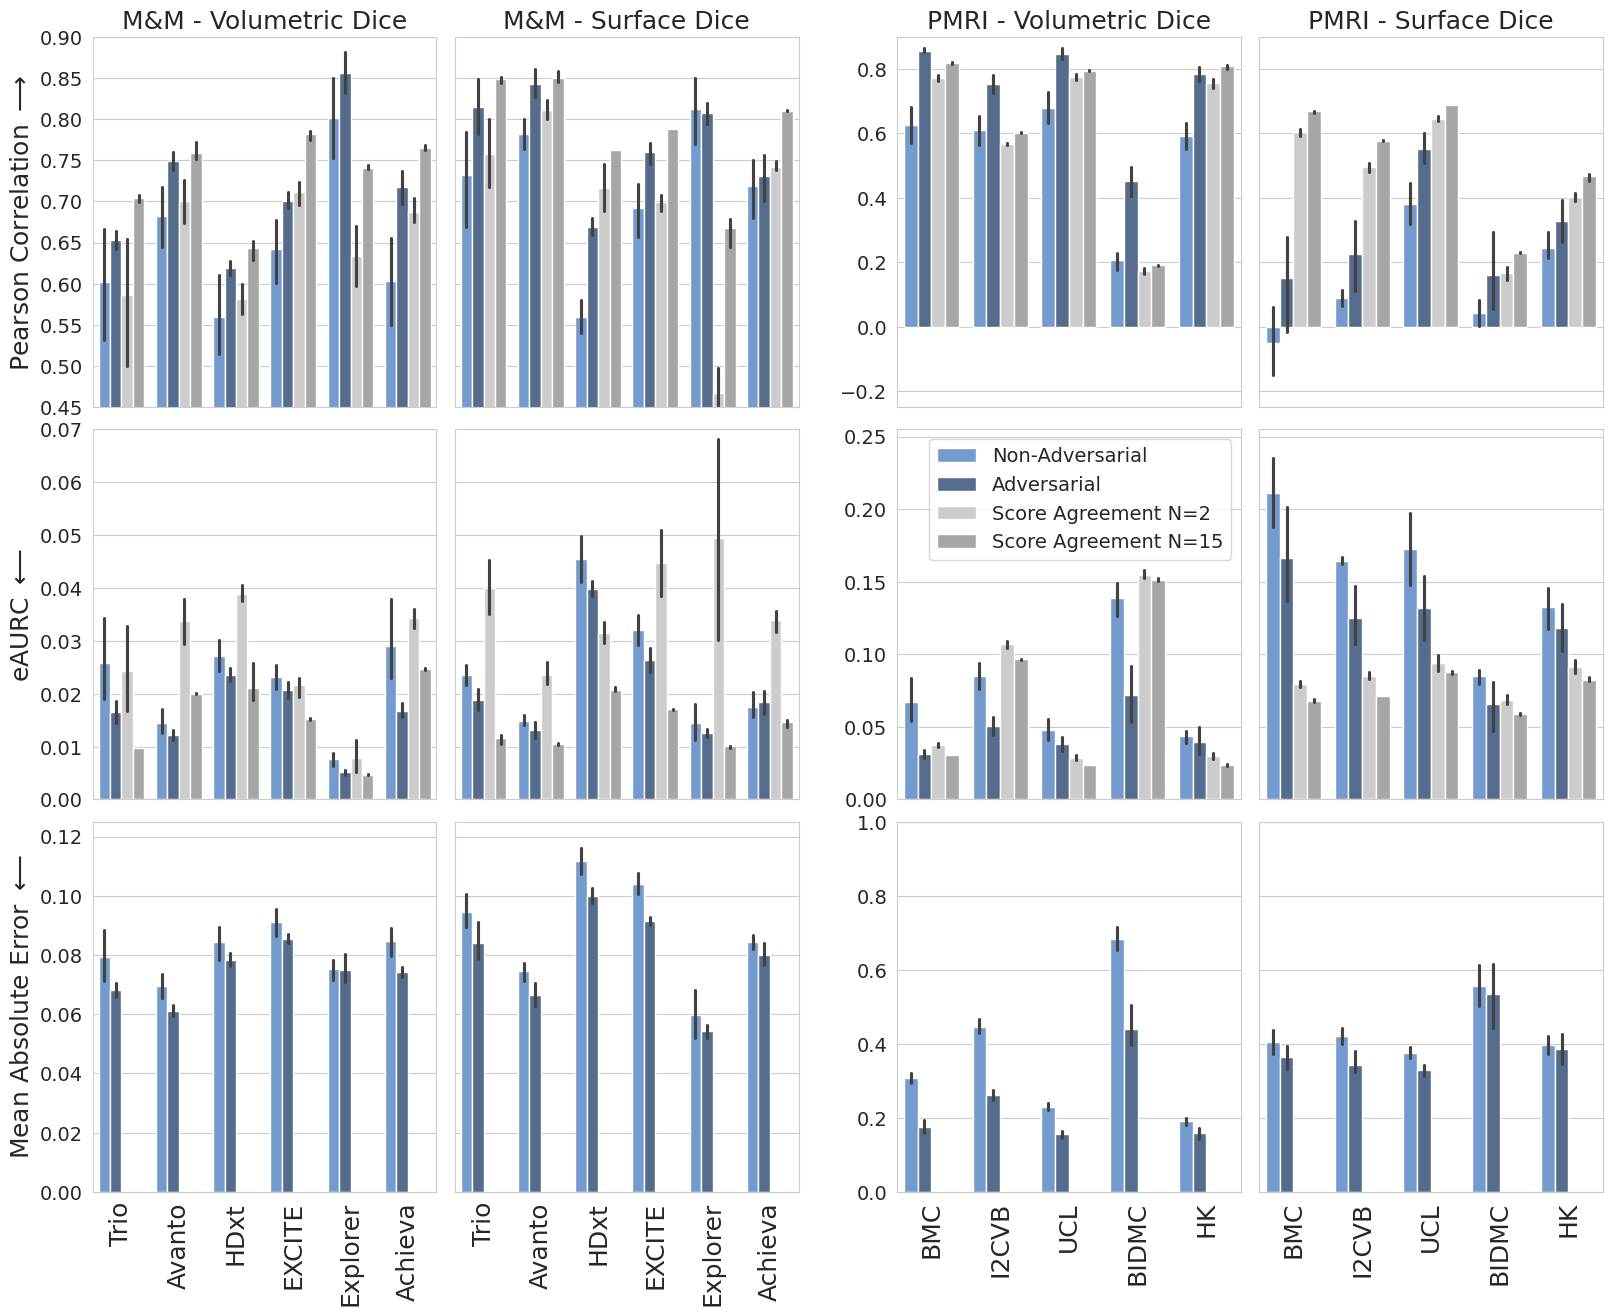

In [ ]:

#TODO
# - Titles
# - Method Names
# - Score Formatting
# - White Space between
# - Transparancy
# - Font size

sns.set_style('whitegrid')

sns.dark_palette("#69d", reverse=True)

colors = [
    (0.4, 0.6, 0.8666666666666667),
    (0.2964599253859186, 0.41923785521534, 0.5848575277771775),
    (0.8, 0.8, 0.8),
    (0.65, 0.65, 0.65),
]

eval_metric_dict = {
    'corr': r'Pearson Correlation $\longrightarrow$',
    'eaurc': r'eAURC $\longleftarrow$',
    'mae': r'Mean Absolute Error $\longleftarrow$'
}
score_dict = {
    'dice': 'Volumetric Dice',
    'surface': 'Surface Dice'
}

dataset_dict = {
    'mnmv2': 'M&M',
    'pmri': 'PMRI'
}


fig, axes = plt.subplots(3, 4, figsize=(20, 15), sharex=False, sharey=False, gridspec_kw = {'wspace':0.17, 'hspace':0.06})

datasets = df['dataset'].unique()
scores = ['dice', 'surface']
fontsize = 18

for i, dataset in enumerate(datasets):
    for j, score in enumerate(scores):
        for k, eval_metric in enumerate(['corr', 'eaurc', 'mae']):
            ax = axes[k, j + i * 2]

            # Filter data for the specific dataset and score
            filtered_data = df[(df['dataset'] == dataset) & (df['score'] == score)]

            # colors = [
            #     (0.4, 0.6, 0.8666666666666667),
            #     (0.2964599253859186, 0.41923785521534, 0.5848575277771775),
            #     (0.8, 0.8, 0.8)
            # ]
            palette = {
                k:v for k,v in zip(hue_order, colors)
            }
            # Barplot for corr
            sns.barplot(
                data=filtered_data,
                x='domain',
                y=eval_metric,
                hue='source',
                ax=ax,
                palette=palette,
                # errorbar=('pi', 100),
                hue_order = hue_order
            )

            # ax.set_ylabel(f'{eval_metric}')

            if dataset == 'mnmv2' and eval_metric == 'corr':
                ax.set_ylim(0.45, 0.90)

            if score == 'surface':
                ax.set_yticklabels([])
                pos = ax.get_position()
                ax.set_position([pos.x0 - 0.02, pos.y0, pos.width, pos.height]) 

            if dataset == 'mnmv2' and eval_metric == 'eaurc':
                ax.set_ylim(0, 0.07)

            if dataset == 'mnmv2' and score == 'dice':
                ax.set_ylabel(eval_metric_dict[eval_metric], fontsize=fontsize)
            else:
                ax.set_ylabel('')

            if dataset == 'pmri' and score == 'dice' and eval_metric == 'eaurc':
                ax.legend(title=None, fontsize=fontsize-4)
            else:
                ax.legend_ = None

            if dataset == 'pmri' and eval_metric == 'corr':
                ax.set_ylim(-0.25, 0.9)

            if dataset == 'pmri' and eval_metric == 'eaurc':
                ax.set_ylim(0, 0.255)

            if eval_metric == 'mae':
                ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=fontsize)

            else:
                ax.set_xticks([])

            if eval_metric == 'mae' and dataset == 'mnmv2':
                ax.set_ylim(0, 0.125)

            if eval_metric == 'mae' and dataset == 'pmri':
                ax.set_ylim(0, 1)

            if eval_metric == 'corr':
                ax.set_title(f"{dataset_dict[dataset]} - {score_dict[score]}", fontsize=fontsize)
                ax.set_xticks([])
                
            if score == 'dice':
                ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
            ax.set_xlabel('')

# Adjust layout and remove overlapping legends
plt.tight_layout()
plt.savefig('../../results/plots/results_all_and_score-agreement-ablation_original-axes.png', bbox_inches='tight', dpi=300)
plt.show()

In [6]:
source

'Score Agreement'

In [9]:
df.source.unique()

array(['Adversarial', 'Non-Adversarial', 'Score Agreement 15',
       'Score Agreement 2'], dtype=object)

In [25]:
root_dir = '../../'
eval_dir = 'results/main_results/'
rows = []

source_translator = {
    'normal': 'Non-Adversarial',
    'adversarial': 'Adversarial',
    'score-agreement-15': 'Score Agreement',
}

hue_order = ['Non-Adversarial', 'Adversarial', 'Score Agreement']
# quantiles = {
#     'mnmv2': {
#         'dice': {
#             'q_80': 0.8923393249511719,
#             'q_90': 0.8359943747520446,
#             'q_95': 0.7769947648048401
#         }, 
#         'surface_dice': {
#             'q_80': 0.8987622618675232,
#             'q_90': 0.6623743534088135, 
#             'q_95': 0.5472338736057282
#         }
#     }, 
#     'pmri': {
#         'dice': {
#             'q_80': 0.8656453490257263,
#             'q_90': 0.7885498404502869,
#             'q_95': 0.7842167615890503
#         }, 
#         'surface_dice': {
#             'q_80': 0.5677419304847717,
#             'q_90': 0.49848026037216187, 
#             'q_95': 0.36147186160087585
#         }
#     }
# }

quantiles = {
    'mnmv2': {
        'dice': {
            'q_80': 0.8865002393722534, 
            'q_90': 0.8443227410316467, 
            'q_95': 0.7935258209705353
        }, 
        'surface_dice': {
            'q_80': 0.8983537554740906, 
            'q_90': 0.6614245891571044, 
            'q_95': 0.5942456066608429
        }
    }, 
    'pmri': {
        'dice': {
            'q_80': 0.9288250088691712, 
            'q_90': 0.9120014429092407, 
            'q_95': 0.8903486222028733
        }, 
        'surface_dice': {
            'q_80': 0.77085782289505, 
            'q_90': 0.6924475610256196,
            'q_95': 0.6237157493829727
        }
    }
}

val_t = 90
# get files for main methods
dirs = os.listdir(root_dir + eval_dir)
dirs = [d for d in dirs if 'Symphony' in d or 'RUNMC' in d]
dirs = [d for d in dirs if '2025' in d and 'in-domain' not in d]

# add rows to dataframe for each method and setting
for dir in dirs:
    file = pkl.load(open(root_dir + eval_dir + dir + '/eval_data.pkl', 'rb'))['evaluation']
    parts = dir.split('_')
    dataset = parts[0]
    source = parts[3]
    if 'finetune' in parts[4]:
        source += f'_{parts[4]}'
    score = parts[2]

    source = source_translator[source]

    for domain in file.keys():
        if 'train' in domain or 'val' in domain:
            continue
        corr = file[domain]['corr'][0].item()
        predicted_risks = torch.cat(file[domain]['predicted_risks'])
        true_risks = torch.cat(file[domain]['original_risks'])
        eaurc, true_risks_aggr, predicted_risks_aggr = eAURC(predicted_risks, true_risks, ret_curves=True)
        
        # print(score)
        score_key = score if score != 'surface' else 'surface_dice'
        threshold = 1 - quantiles[dataset][score_key][f'q_{val_t}']
        # print(f'{dataset} {source} {score} {domain} {threshold}')
        predicted_score_over_threshold = predicted_risks < threshold
        true_score_over_threshold = true_risks < threshold
        acc_at_threshold = accuracy_score(true_score_over_threshold.cpu().numpy(), predicted_score_over_threshold.cpu().numpy())
        frac_over_threshold = true_score_over_threshold.float().mean().item()
        mae = torch.abs(predicted_risks - true_risks).mean().item()

        # f1_at_thresholds = []
        # frac_over_thresholds = []
        # x = []
        
        # for threshold in torch.linspace(0, 1, 101):
        #     predicted_score_over_threshold = predicted_risks < threshold
        #     true_score_over_threshold = true_risks < threshold
        #     f1_at_thresholds.append(f1_score(true_score_over_threshold.cpu().numpy(), predicted_score_over_threshold.cpu().numpy()))
        #     frac_over_thresholds.append(true_score_over_threshold.float().mean().item())
        #     x.append(threshold.item())
        
        # predicted_score_at_50 = predicted_risks < 0.5
        # true_score_at_50 = true_risks < 0.5
        # f1_at_50 = f1_score(true_score_at_50.cpu().numpy(), predicted_score_at_50.cpu().numpy())

        # predicted_score_at_80 = predicted_risks < 0.2
        # true_score_at_80 = true_risks < 0.2
        # f1_at_80 = f1_score(true_score_at_80.cpu().numpy(), predicted_score_at_80.cpu().numpy())


        rows.append(
            {
                'dataset': dataset,
                'source': source,
                'score': score,
                'domain': domain,
                'corr': corr,
                'eaurc': eaurc.item(),
                f'acc_at_threshold': acc_at_threshold,
                f'frac_over_threshold': frac_over_threshold,
                'mae': mae,
            }
        )

        # rows.append(
        #     {
        #         'dataset': dataset,
        #         'source': source,
        #         'score': score,
        #         'domain': domain,
        #         'corr': corr,
        #         'eaurc': eaurc.item(),
        #         f'f1s': f1_at_thresholds,
        #         f'fracs': frac_over_thresholds,
        #         'x': x,
        #     }
        # )


# add rows for score agreement competitor
for root, _, files in os.walk(root_dir + eval_dir):
    for filename in files:
        if 'score-agreement' in filename:
            parts = filename.split('_')
            dataset = parts[0]
            source = parts[2].split('.')[0]

            if 'in-domain' in filename or 'train-val' in filename:
                continue


            if 'score-agreement-15' in source:
                source = source_translator['score-agreement-15']
            if 'score-agreement-2' in source:
                continue
            data = torch.load(root + filename)
            for domain, values in data.items():
                if 'train' in domain or 'val' in domain:
                    continue

                volume_agreement = values['scores']['dice_agreement']
                volume_dice = values['scores']['dice']
                volume_corr = torch.corrcoef(torch.stack([volume_agreement, volume_dice], dim=0))[0,1].item()
                volume_predicted_risks = 1 - volume_agreement
                volume_true_risks = 1 - volume_dice
                volume_eaurc, _, _ = eAURC(volume_predicted_risks, volume_true_risks, ret_curves=True)


                rows.append(
                    {
                        'dataset': dataset,
                        'source': source,
                        'score': 'dice',
                        'domain': domain,
                        'corr': volume_corr,
                        'eaurc': volume_eaurc.item(),
                    }
                )
                
                surface_agreement = values['scores']['surface_agreement']
                surface_dice = values['scores']['surface']
                surface_corr = torch.corrcoef(torch.stack([surface_agreement, surface_dice], dim=0))[0,1].item()
                surface_predicted_risks = 1 - surface_agreement
                surface_true_risks = 1 - surface_dice
                surface_eaurc, _, _ = eAURC(surface_predicted_risks, surface_true_risks, ret_curves=True)

                rows.append(
                    {
                        'dataset': dataset,
                        'source': source,
                        'score': 'surface',
                        'domain': domain,
                        'corr': surface_corr,
                        'eaurc': surface_eaurc.item(),
                    }
                )


# combine to dataframe
df = pd.DataFrame(rows)


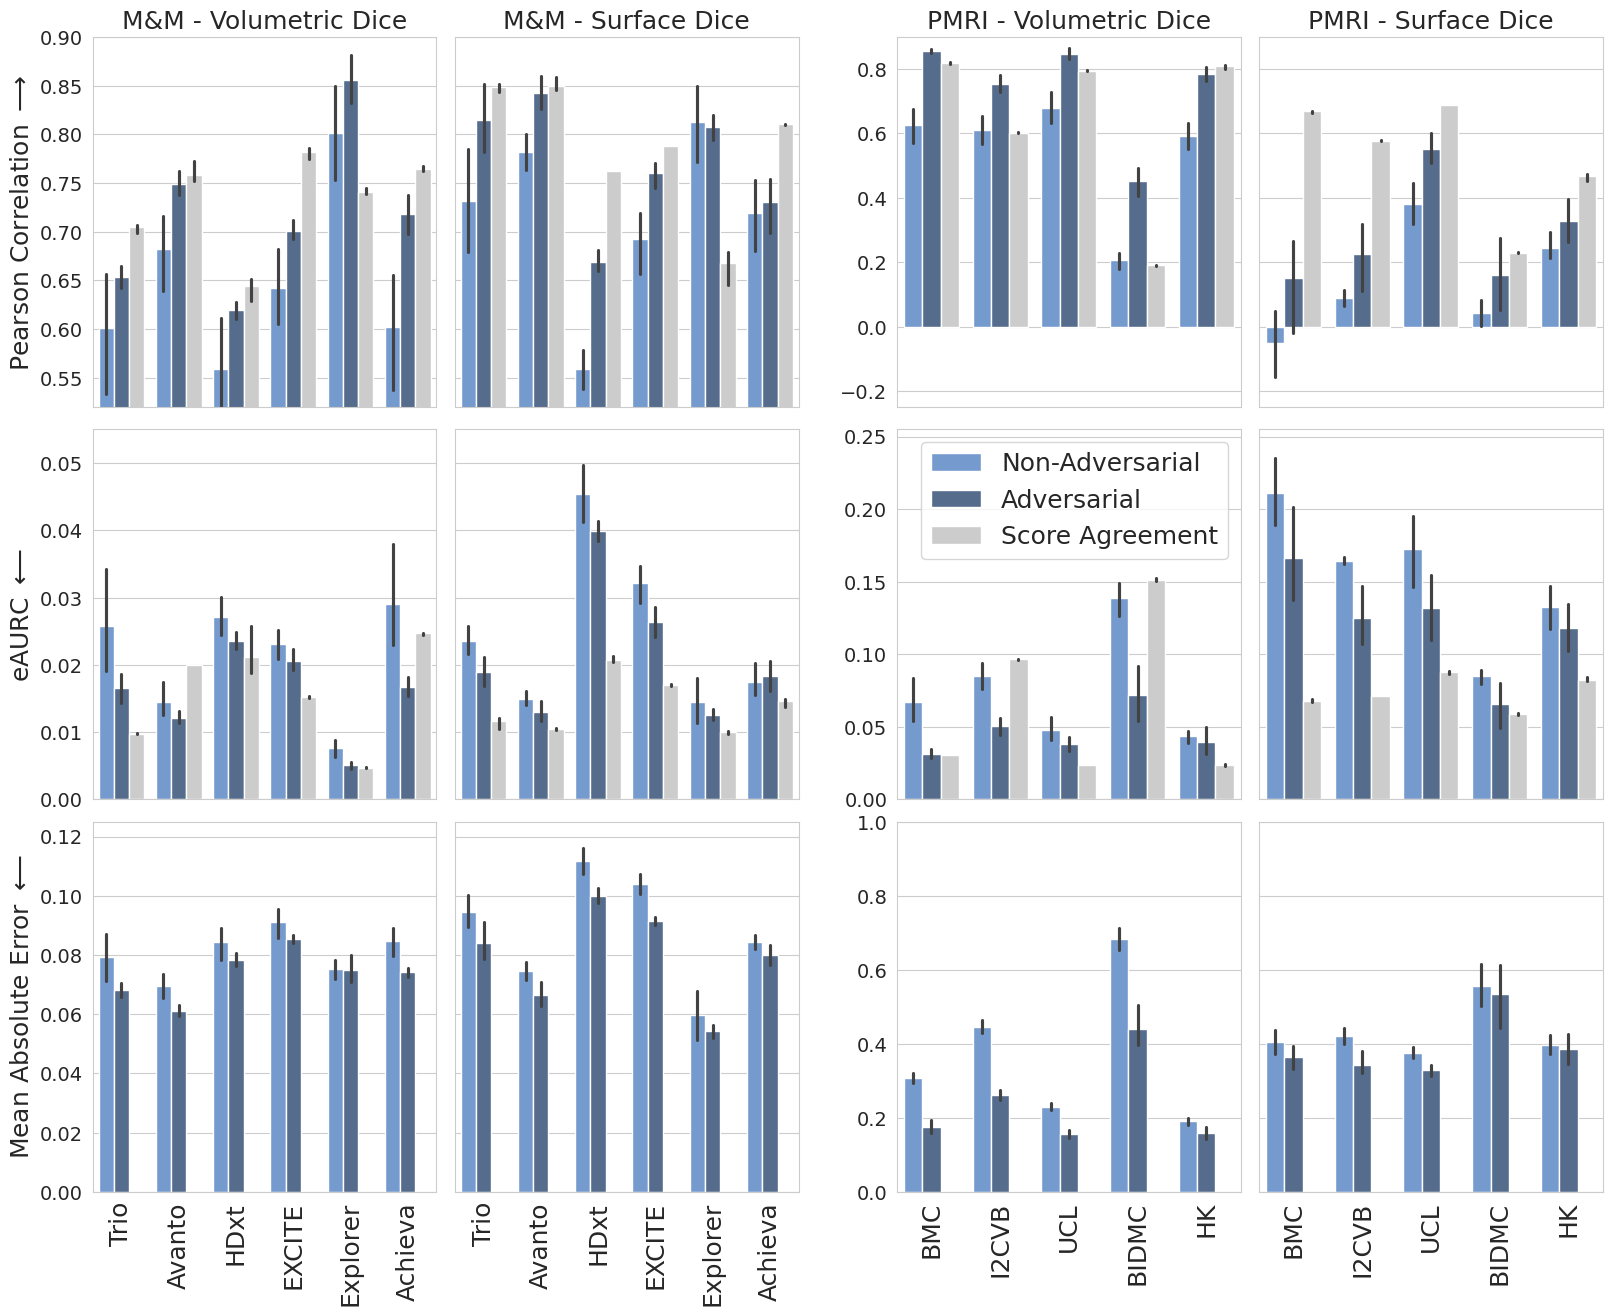

In [ ]:

#TODO
# - Titles
# - Method Names
# - Score Formatting
# - White Space between
# - Transparancy
# - Font size

sns.set_style('whitegrid')

sns.dark_palette("#69d", reverse=True)

colors = [
    (0.4, 0.6, 0.8666666666666667),
    (0.2964599253859186, 0.41923785521534, 0.5848575277771775),
    (0.8, 0.8, 0.8),
    
]

eval_metric_dict = {
    'corr': r'Pearson Correlation $\longrightarrow$',
    'eaurc': r'eAURC $\longleftarrow$',
    'mae': r'Mean Absolute Error $\longleftarrow$'
}
score_dict = {
    'dice': 'Volumetric Dice',
    'surface': 'Surface Dice'
}

dataset_dict = {
    'mnmv2': 'M&M',
    'pmri': 'PMRI'
}


fig, axes = plt.subplots(3, 4, figsize=(20, 15), sharex=False, sharey=False, gridspec_kw = {'wspace':0.17, 'hspace':0.06})

datasets = df['dataset'].unique()
scores = ['dice', 'surface']
fontsize = 18

for i, dataset in enumerate(datasets):
    for j, score in enumerate(scores):
        for k, eval_metric in enumerate(['corr', 'eaurc', 'mae']):
            ax = axes[k, j + i * 2]

            # Filter data for the specific dataset and score
            filtered_data = df[(df['dataset'] == dataset) & (df['score'] == score)]

            # colors = [
            #     (0.4, 0.6, 0.8666666666666667),
            #     (0.2964599253859186, 0.41923785521534, 0.5848575277771775),
            #     (0.8, 0.8, 0.8)
            # ]
            palette = {
                k:v for k,v in zip(hue_order, colors)
            }
            # Barplot for corr
            sns.barplot(
                data=filtered_data,
                x='domain',
                y=eval_metric,
                hue='source',
                ax=ax,
                palette=palette,
                # errorbar=('pi', 100),
                hue_order = hue_order
            )

            ax.set_ylabel(f'{eval_metric}')

            if dataset == 'mnmv2' and eval_metric == 'corr':
                ax.set_ylim(0.52, 0.90)

            if score == 'surface':
                ax.set_yticklabels([])
                pos = ax.get_position()
                ax.set_position([pos.x0 - 0.02, pos.y0, pos.width, pos.height]) 

            if dataset == 'mnmv2' and eval_metric == 'eaurc':
                ax.set_ylim(0, 0.055)

            if dataset == 'mnmv2' and score == 'dice':
                ax.set_ylabel(eval_metric_dict[eval_metric], fontsize=fontsize)
            else:
                ax.set_ylabel('')

            if dataset == 'pmri' and score == 'dice' and eval_metric == 'eaurc':
                ax.legend(title=None, fontsize=fontsize)
            else:
                ax.legend_ = None

            if dataset == 'pmri' and eval_metric == 'corr':
                ax.set_ylim(-0.25, 0.9)

            if dataset == 'pmri' and eval_metric == 'eaurc':
                ax.set_ylim(0, 0.255)

            if eval_metric == 'mae':
                ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=fontsize)

            else:
                ax.set_xticks([])

            if eval_metric == 'mae' and dataset == 'mnmv2':
                ax.set_ylim(0, 0.125)

            if eval_metric == 'mae' and dataset == 'pmri':
                ax.set_ylim(0, 1)

            if eval_metric == 'corr':
                ax.set_title(f"{dataset_dict[dataset]} - {score_dict[score]}", fontsize=fontsize)
                ax.set_xticks([])
                
            if score == 'dice':
                ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
            ax.set_xlabel('')

# Adjust layout and remove overlapping legends
plt.tight_layout()
plt.savefig('../../results/plots/results_all.png', bbox_inches='tight', dpi=300)
plt.show()

In [78]:
root_dir = '../../'
rows = []
source_translator = {
    'adversarial_beta005': 'Beta 0.05',
    'adversarial': 'Beta 0.1',
    'adversarial_beta02': 'Beta 0.2',
    'adversarial_finetune': 'Fine-Tuning'
}

hue_order = ['Beta 0.05', 'Beta 0.1', 'Beta 0.2', 'Fine-Tuning']

# ablation for beta
eval_dir = 'results/ablation/beta_adjustment/'

# get files for main methods
dirs = os.listdir(root_dir + eval_dir)

# add rows to dataframe for each method and setting
for dir in dirs:
    file = pkl.load(open(root_dir + eval_dir + dir + '/eval_data.pkl', 'rb'))['evaluation']
    parts = dir.split('_')
    dataset = parts[0]
    source = parts[3]
    if 'beta' in parts[4]:
        source += f'_{parts[4]}'
    score = parts[2]

    source = source_translator[source]

    for domain in file.keys():
        if 'train' in domain or 'val' in domain:
            continue
        corr = file[domain]['corr'][0].item()
        predicted_risks = torch.cat(file[domain]['predicted_risks'])
        true_risks = torch.cat(file[domain]['original_risks'])
        eaurc, true_risks_aggr, predicted_risks_aggr = eAURC(predicted_risks, true_risks, ret_curves=True)

        rows.append(
            {
                'dataset': dataset,
                'source': source,
                'score': score,
                'domain': domain,
                'corr': corr,
                'eaurc': eaurc.item(),
            }
        )


# ablation for finetuning
eval_dir = 'results/ablation/finetuning/'


# get files for main methods
dirs = os.listdir(root_dir + eval_dir)

# add rows to dataframe for each method and setting
for dir in dirs:
    print(dir)
    file = pkl.load(open(root_dir + eval_dir + dir + '/eval_data.pkl', 'rb'))['evaluation']
    parts = dir.split('_')
    dataset = parts[0]
    source = parts[3] + '_finetune'
    score = parts[2]

    source = source_translator[source]
    print(parts)
    for domain in file.keys():
        if 'train' in domain or 'val' in domain:
            continue
        corr = file[domain]['corr'][0].item()
        predicted_risks = torch.cat(file[domain]['predicted_risks'])
        true_risks = torch.cat(file[domain]['original_risks'])
        mae = torch.abs(predicted_risks - true_risks).mean().item()
        eaurc, true_risks_aggr, predicted_risks_aggr = eAURC(predicted_risks, true_risks, ret_curves=True)

        rows.append(
            {
                'dataset': dataset,
                'source': source,
                'score': score,
                'domain': domain,
                'corr': corr,
                'eaurc': eaurc.item(),
                'mae': mae
            }
        )

df = pd.DataFrame(rows)

mnmv2_Symphony_dice_adversarial_finetune_2025-01-29-09-47
['mnmv2', 'Symphony', 'dice', 'adversarial', 'finetune', '2025-01-29-09-47']
mnmv2_Symphony_dice_adversarial_finetune_2025-01-29-09-58
['mnmv2', 'Symphony', 'dice', 'adversarial', 'finetune', '2025-01-29-09-58']
mnmv2_Symphony_dice_adversarial_finetune_2025-01-29-10-09
['mnmv2', 'Symphony', 'dice', 'adversarial', 'finetune', '2025-01-29-10-09']
mnmv2_Symphony_dice_adversarial_finetune_2025-01-29-10-31
['mnmv2', 'Symphony', 'dice', 'adversarial', 'finetune', '2025-01-29-10-31']
mnmv2_Symphony_dice_adversarial_finetune_2025-01-29-10-20
['mnmv2', 'Symphony', 'dice', 'adversarial', 'finetune', '2025-01-29-10-20']


In [79]:
dirs

['mnmv2_Symphony_dice_adversarial_finetune_2025-01-29-09-47',
 'mnmv2_Symphony_dice_adversarial_finetune_2025-01-29-09-58',
 'mnmv2_Symphony_dice_adversarial_finetune_2025-01-29-10-09',
 'mnmv2_Symphony_dice_adversarial_finetune_2025-01-29-10-31',
 'mnmv2_Symphony_dice_adversarial_finetune_2025-01-29-10-20']

In [82]:
# Group by source and domain, calculate mean and std
grouped = df.groupby(["source", "domain"]).agg(
    corr_avg=("corr", "mean"),
    corr_std=("corr", "std"),
    eaurc_avg=("eaurc", "mean"),
    eaurc_std=("eaurc", "std"),
).reset_index()

# Prepare LaTeX table
latex_table = "\\begin{table}[ht]\n\\centering\n\\caption{Summary Table}\n\\label{tab:summary}\n"
latex_table += "\\begin{tabular}{l" + "c" * len(grouped['domain'].unique()) + "}\n\\hline\n"
latex_table += "Method & " + " & ".join(grouped['domain'].unique()) + " \\\\\n\\hline\n"

methods = grouped['source'].unique()
for method in methods:
    latex_table += f"\\multirow{{2}}{{*}}{{{method}}} "
    corr_row = " & ".join(
        f"${str(round(row.corr_avg, 3)).lstrip('0')}\\pm{str(round(row.corr_std, 3)).lstrip('0')}$"
        for _, row in grouped[grouped['source'] == method].iterrows()
    )
    eaurc_row = " & ".join(
        f"${str(round(row.eaurc_avg, 3)).lstrip('0')}\\pm{str(round(row.eaurc_std, 3)).lstrip('0')}$"
        for _, row in grouped[grouped['source'] == method].iterrows()
    )
    latex_table += corr_row + " \\\\\n"
    latex_table += " & " + eaurc_row + " \\\\\n\\hline\n"

latex_table += "\\end{tabular}\n\\end{table}"

print(latex_table)

\begin{table}[ht]
\centering
\caption{Summary Table}
\label{tab:summary}
\begin{tabular}{lcccccc}
\hline
Method & Achieva & Avanto & EXCITE & Explorer & HDxt & Trio \\
\hline
\multirow{2}{*}{Beta 0.05} $.675\pm.018$ & $.736\pm.018$ & $.662\pm.032$ & $.847\pm.019$ & $.608\pm.035$ & $.624\pm.035$ \\
 & $.019\pm.003$ & $.012\pm.001$ & $.023\pm.003$ & $.004\pm.001$ & $.025\pm.002$ & $.018\pm.002$ \\
\hline
\multirow{2}{*}{Beta 0.1} $.718\pm.024$ & $.749\pm.015$ & $.7\pm.013$ & $.856\pm.033$ & $.619\pm.012$ & $.654\pm.015$ \\
 & $.017\pm.002$ & $.012\pm.001$ & $.021\pm.002$ & $.005\pm.001$ & $.024\pm.002$ & $.016\pm.003$ \\
\hline
\multirow{2}{*}{Beta 0.2} $.719\pm.037$ & $.779\pm.023$ & $.695\pm.016$ & $.85\pm.041$ & $.631\pm.019$ & $.616\pm.044$ \\
 & $.017\pm.001$ & $.012\pm.001$ & $.022\pm.002$ & $.007\pm.004$ & $.023\pm.002$ & $.017\pm.001$ \\
\hline
\multirow{2}{*}{Fine-Tuning} $.73\pm.033$ & $.754\pm.013$ & $.716\pm.017$ & $.858\pm.036$ & $.632\pm.014$ & $.668\pm.011$ \\
 & $.016\pm.

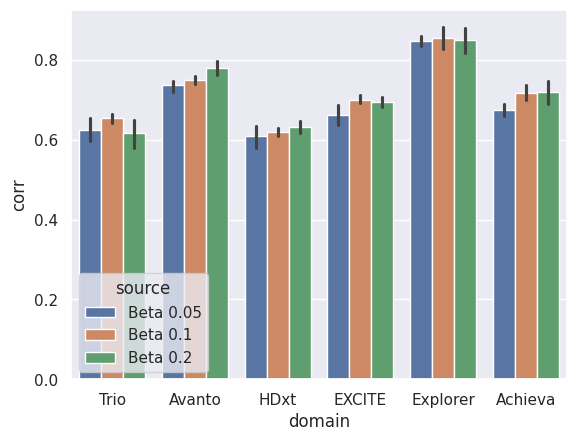

In [49]:
# hue_order = ['adversarial_beta005', 'adversarial', 'adversarial_beta02']

# colors = [
#     (0.4, 0.6, 0.8666666666666667),
#     (0.2964599253859186, 0.41923785521534, 0.5848575277771775),
#     (0.8, 0.8, 0.8)
# ]
# palette = {
#     k:v for k,v in zip(hue_order, colors)
# }
sns.barplot(
    data=df,
    x='domain',
    y='corr',
    hue='source',
    # palette=palette,
    # errorbar=('pi', 100),
    hue_order = hue_order
)

plt.savefig('../../results/plots/ablation_beta_corr.png', bbox_inches='tight', dpi=300)

In [220]:
sns.set_palette('deep')

In [221]:
sns.color_palette()

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

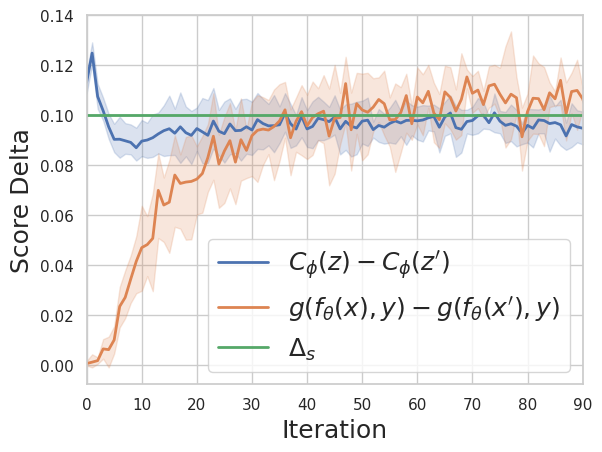

In [222]:
wandb_df = pd.read_csv('../../results/wandb_export.csv')
prefixes = list(set(col.split(' - ')[0] for col in wandb_df.columns if ' - ' in col))
# Create a new DataFrame with only the relevant columns for each prefix
rows = []
for prefix in prefixes:
    # Extract relevant columns for this prefix
    observed_delta_col = f"{prefix} - observed_delta"
    true_score_delta_col = f"{prefix} - true_score_delta"
    
    if observed_delta_col in wandb_df.columns and true_score_delta_col in wandb_df.columns:
        # Add rows to the new DataFrame
        for idx, row in wandb_df.iterrows():
            rows.append({
                'idx': idx,                
                'name': prefix,
                'score': r"$C_\phi(z) - C_\phi(z')$",
                'value': row[observed_delta_col],
            })
            rows.append({
                'idx': idx,                
                'name': prefix,
                'score': r"$g(f_\theta(x), y) - g(f_\theta(x'),y)$",
                'value':  row[true_score_delta_col]
            })

            rows.append({
                'idx': idx,                
                'name': prefix,
                'score': r"$\Delta_s$",
                'value': 0.1
            })
# $$C_\phi(z') \approx C_\phi(z)
# g(f_\theta(x'), y) \approx g(f_\theta(x), y)
# Create the resulting DataFrame
result_df = pd.DataFrame(rows)

sns.lineplot(
    data=result_df,
    x='idx',
    y='value',
    hue='score',
    linewidth=2
)
plt.xlabel('Iteration', fontsize=18)
plt.ylabel('Score Delta', fontsize=18)
plt.legend(title=None, fontsize=18)

# Add the horizontal line at 0.1
# ax.axhline(y=0.1, color='red', linestyle='--', label=r'$\Delta_s$')

# Update the legend
# ax.legend(title=None, fontsize=18)
plt.xlim(0, 90)
# plt.show()
# plt.title('Impact of adversarial training on score deltas')
plt.savefig('../../results/plots/delta_scores.png', bbox_inches='tight', dpi=300)

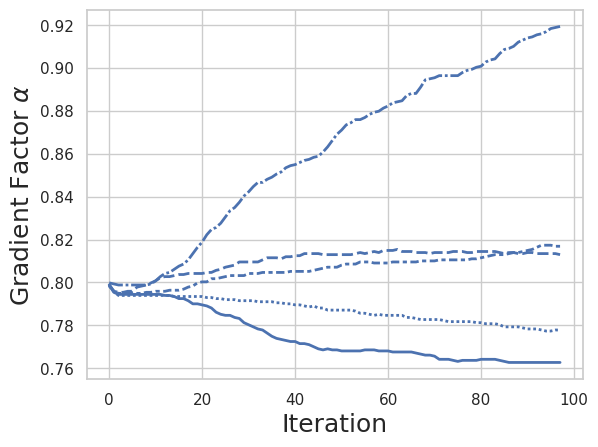

In [223]:
wandb_df = pd.read_csv('../../results/wandb_export2.csv')
prefixes = list(set(col.split(' - ')[0] for col in wandb_df.columns if ' - ' in col))

# Create a new DataFrame with only the relevant columns for each prefix
rows = []
for prefix in prefixes:
    # Extract relevant columns for this prefix
    gradient_factor_col = f"{prefix} - gradient_factor"
    
    if gradient_factor_col in wandb_df.columns:
        # Add rows to the new DataFrame
        for idx, row in wandb_df.iterrows():
            rows.append({
                'idx': idx,                
                'name': prefix,
                'score': 'Gradient Factor',
                'value': row[gradient_factor_col],
            })

# Create the resulting DataFrame
result_df = pd.DataFrame(rows)

sns.lineplot(
    data=result_df,
    x='idx',
    y='value',
    style='name',
    linewidth=2
)
plt.xlabel('Iteration', fontsize=18)
plt.ylabel(r'Gradient Factor $\alpha$', fontsize=18)
plt.legend('',frameon=False)

# plt.title('Gradient factors across runs with similar hyperparameters')
plt.savefig('../../results/plots/gradient_factors.png', bbox_inches='tight', dpi=300)

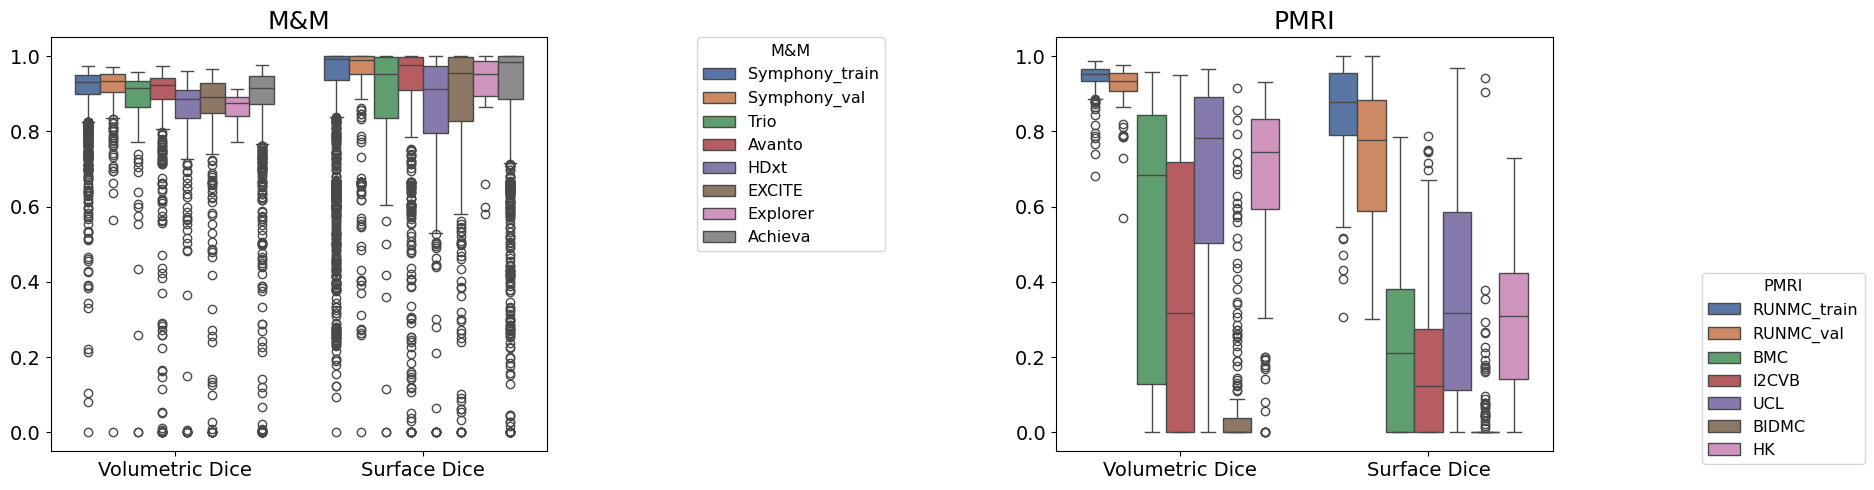

In [11]:
# Unet performance

metrics = torch.load('../../results/unet_eval.pt')
rows = []

score_table = {
    'dice': 'Volumetric Dice',
    'surface_dice': 'Surface Dice'
}

for dataset, dataset_metrics in metrics.items():
    # print(dataset)
    for domain, domain_metrics in dataset_metrics.items():
        # print(domain)
        dice = domain_metrics['dice']
        # print(f'Dice Correlation: {dice_correlation}')
        surface_dice = domain_metrics['surface_dice']
        # print(f'Surface Dice Correlation: {surface_dice_correlation}')
        for score in ['dice', 'surface_dice']:
            value = dice if score == 'dice' else surface_dice
            for v in value:
                rows.append(
                    {
                        'Dataset': dataset,
                        'Domain': domain,
                        'value': v.item(),
                        'score': score_table[score]
                    }
                )

df = pd.DataFrame(rows)
fig, ax = plt.subplots(1, 2, figsize=(25, 5))

# M&M plot
sns.boxplot(x='score', y='value', hue='Domain', data=df[df['Dataset'] == 'mnmv2'], ax=ax[0])
ax[0].set_title('M&M', fontsize=18)
ax[0].set_ylabel('')
ax[0].set_xlabel('')
ax[0].tick_params(axis='both', which='major', labelsize=14)

# Move M&M legend
legend0 = ax[0].legend(title='M&M', bbox_to_anchor=(1.3, 1), loc='upper left', borderaxespad=0, fontsize=11.5)
plt.setp(legend0.get_title(),fontsize=11.5)

# PMRI plot
sns.boxplot(x='score', y='value', hue='Domain', data=df[df['Dataset'] == 'pmri'], ax=ax[1])
ax[1].set_title('PMRI', fontsize=18)
ax[1].set_ylabel('')
ax[1].set_xlabel('')
ax[1].tick_params(axis='both', which='major', labelsize=14)

# Move PMRI legend
legend1 = ax[1].legend(title='PMRI', bbox_to_anchor=(1.3, 0.2), loc='center left', borderaxespad=0, fontsize=11.5)
plt.setp(legend1.get_title(),fontsize=11.5)



# # Adjust layout to make space for the legends
plt.tight_layout(rect=[0, 0, 0.8, 1])  # Leave space on the right for legends
fig.savefig('../../results/plots/unet_eval.png', dpi=300)

TypeError: 'NoneType' object is not iterable

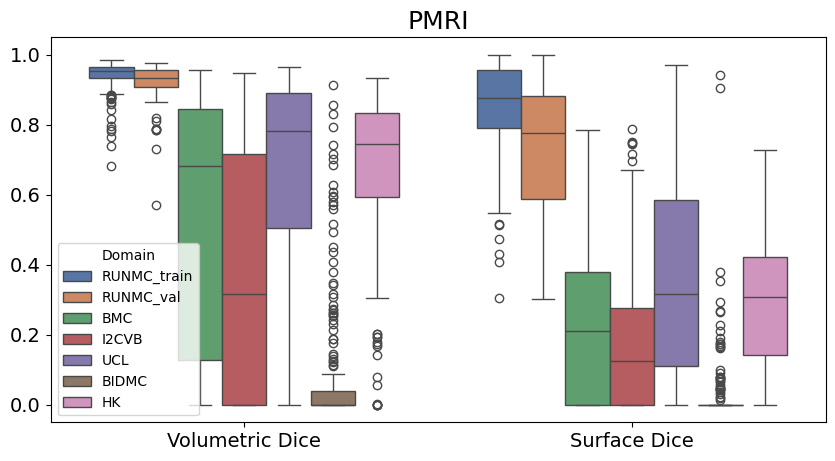

In [8]:
sns.set_palette('deep')

# --- M&M Plot ---
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(
    x='score',
    y='value',
    hue='Domain',
    data=df[df['Dataset'] == 'mnmv2'],
    ax=ax
)
ax.set_title('M&M', fontsize=18)
ax.set_ylabel('')
ax.set_xlabel('')
ax.tick_params(axis='both', which='major', labelsize=14)

# Move legend for M&M
legend_mnm = ax.legend(
    title='M&M',
    bbox_to_anchor=(1.3, 1),
    loc='upper left',
    borderaxespad=0,
    fontsize=10
)
plt.setp(legend_mnm.get_title(), fontsize=10)

plt.tight_layout(rect=[0, 0, 0.8, 1])
fig.savefig('../../results/plots/unet_eval_mnm.png', dpi=300)
plt.close(fig)

# --- PMRI Plot ---
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(
    x='score',
    y='value',
    hue='Domain',
    data=df[df['Dataset'] == 'pmri'],
    ax=ax
)
ax.set_title('PMRI', fontsize=18)
ax.set_ylabel('')
ax.set_xlabel('')
ax.tick_params(axis='both', which='major', labelsize=14)
# ax.legend(None)
# Move legend for PMRI
legend_pmri = ax.legend(
    title='PMRI',
    bbox_to_anchor=(1.3, 0.8),
    loc='upper left',
    borderaxespad=0,
    fontsize=10
)
plt.setp(legend_pmri.get_title(), fontsize=10)

plt.tight_layout(rect=[0, 0, 0.8, 1])
fig.savefig('../../results/plots/unet_eval_pmri.png', dpi=300)
plt.close(fig)

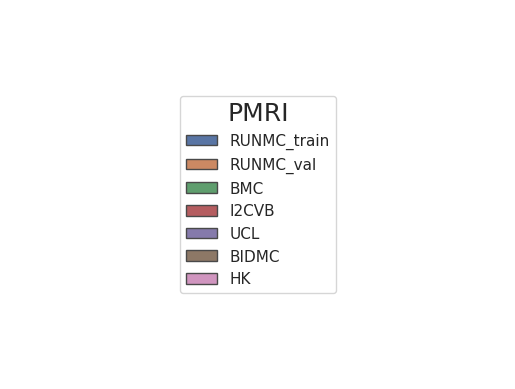

In [242]:
handles, labels = ax[1].get_legend_handles_labels()
original_legend = ax[1].get_legend()
legend_title = original_legend.get_title().get_text()
fig_legend = plt.figure()
ax_legend = fig_legend.add_subplot(111)

# Place the legend in the new figure, including title and box
ax_legend.legend(
    handles, 
    labels, 
    loc='center', 
    frameon=True,            # draw the box
    title=legend_title       # use original legend title
)
ax_legend.axis('off')
fig_legend.savefig('../../results/plots/legend_unet_PMRI.png', bbox_inches='tight') 

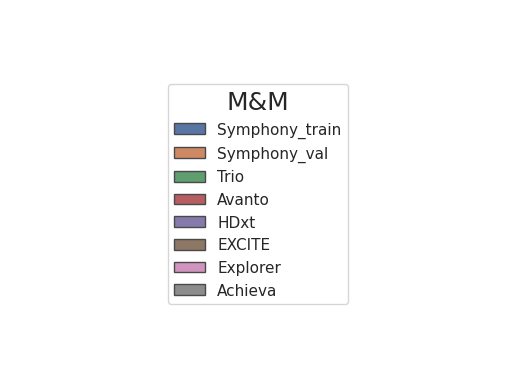

In [241]:
handles, labels = ax[0].get_legend_handles_labels()
original_legend = ax[0].get_legend()
legend_title = original_legend.get_title().get_text()
fig_legend = plt.figure()
ax_legend = fig_legend.add_subplot(111)

# Place the legend in the new figure, including title and box
ax_legend.legend(
    handles, 
    labels, 
    loc='center', 
    frameon=True,            # draw the box
    title=legend_title       # use original legend title
)
ax_legend.axis('off')
fig_legend.savefig('../../results/plots/legend_unet_MNM.png', bbox_inches='tight') 